# Traffic Data Viewer
A Jupyter Notebook for visualizing the data

Note: The data is stored assuming UTC timezone, however most of these functions take the parameter `local_tz`, allowing you to convert to the timezone of your choice. The default value of `local_tz` is US/Pacific.

In [2]:
%matplotlib notebook

In [3]:
import sys
sys.path.append('../')

In [24]:
import seaborn as sns
import traffic.dbutil as dbutil

In [170]:
d = dbutil.get_travel_times([96])

In [171]:
route_name = d['Description'].any()

In [172]:
def weekdayName(i):
    return ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"][i]

In [173]:
d1 = d.weekdays()
d1 = d1.hours_filter(15, 18)
d1['Hour'] = d1.apply(lambda row: row['TimeUpdated'].hour, axis=1)
d1['Weekday'] = d1.apply(lambda row: weekdayName(row['TimeUpdated'].weekday()), axis=1)
tidy = d1[['Weekday','Hour', 'CurrentTime']]
tidy = tidy.rename(columns={'CurrentTime': 'TravelTimeMinutes'})

<IPython.core.display.Javascript object>


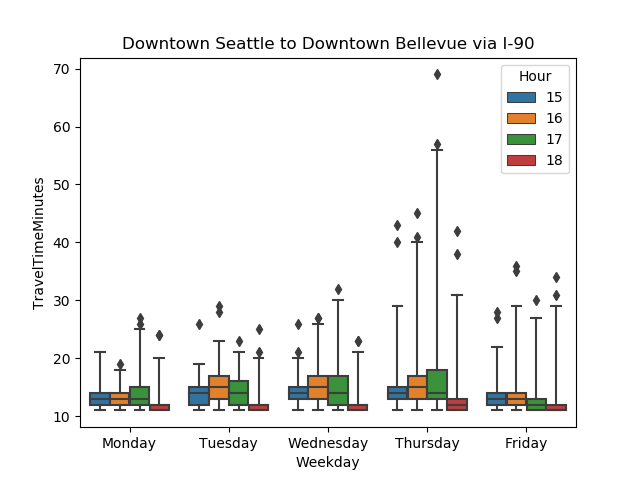

Text(0.5,1,'Downtown Seattle to Downtown Bellevue via I-90')

In [177]:
sns.boxplot(x="Weekday", y="TravelTimeMinutes", hue="Hour", data=tidy, whis=[1, 99]).set_title(route_name)

<IPython.core.display.Javascript object>


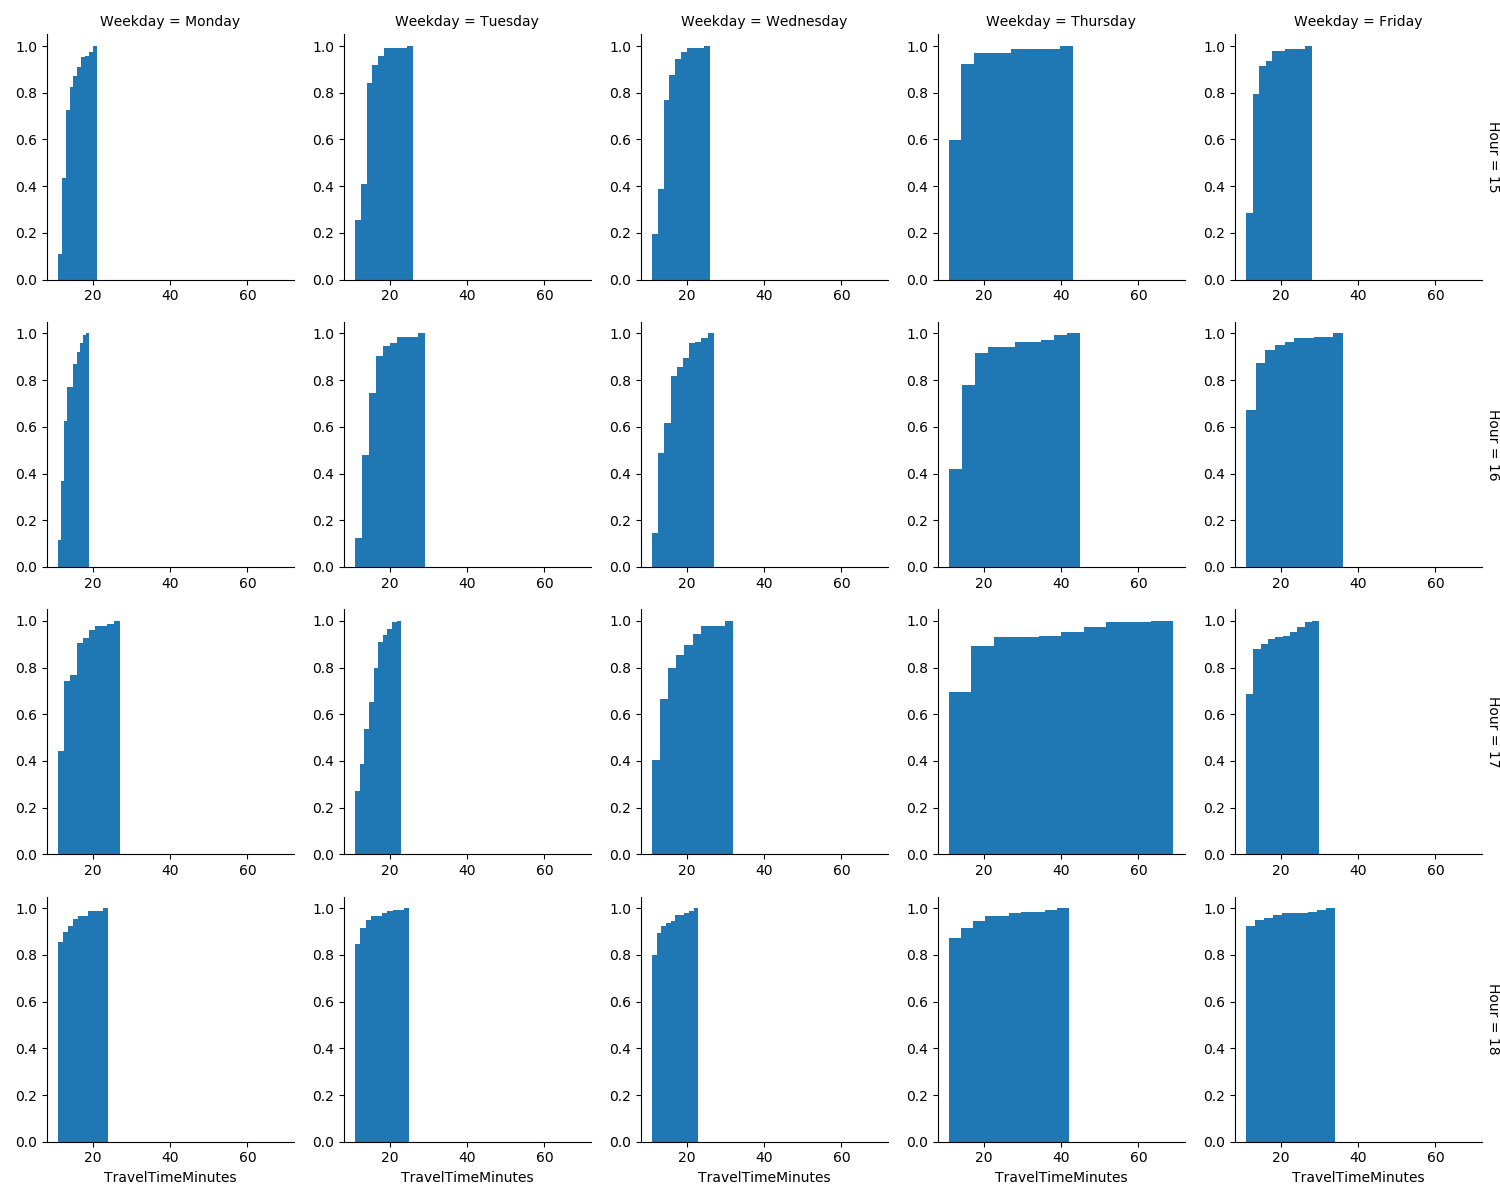

In [179]:
g = sns.FacetGrid(tidy, col="Weekday", row="Hour", margin_titles=True)
g.map(plt.hist, "TravelTimeMinutes", normed=True, cumulative=True)

<IPython.core.display.Javascript object>


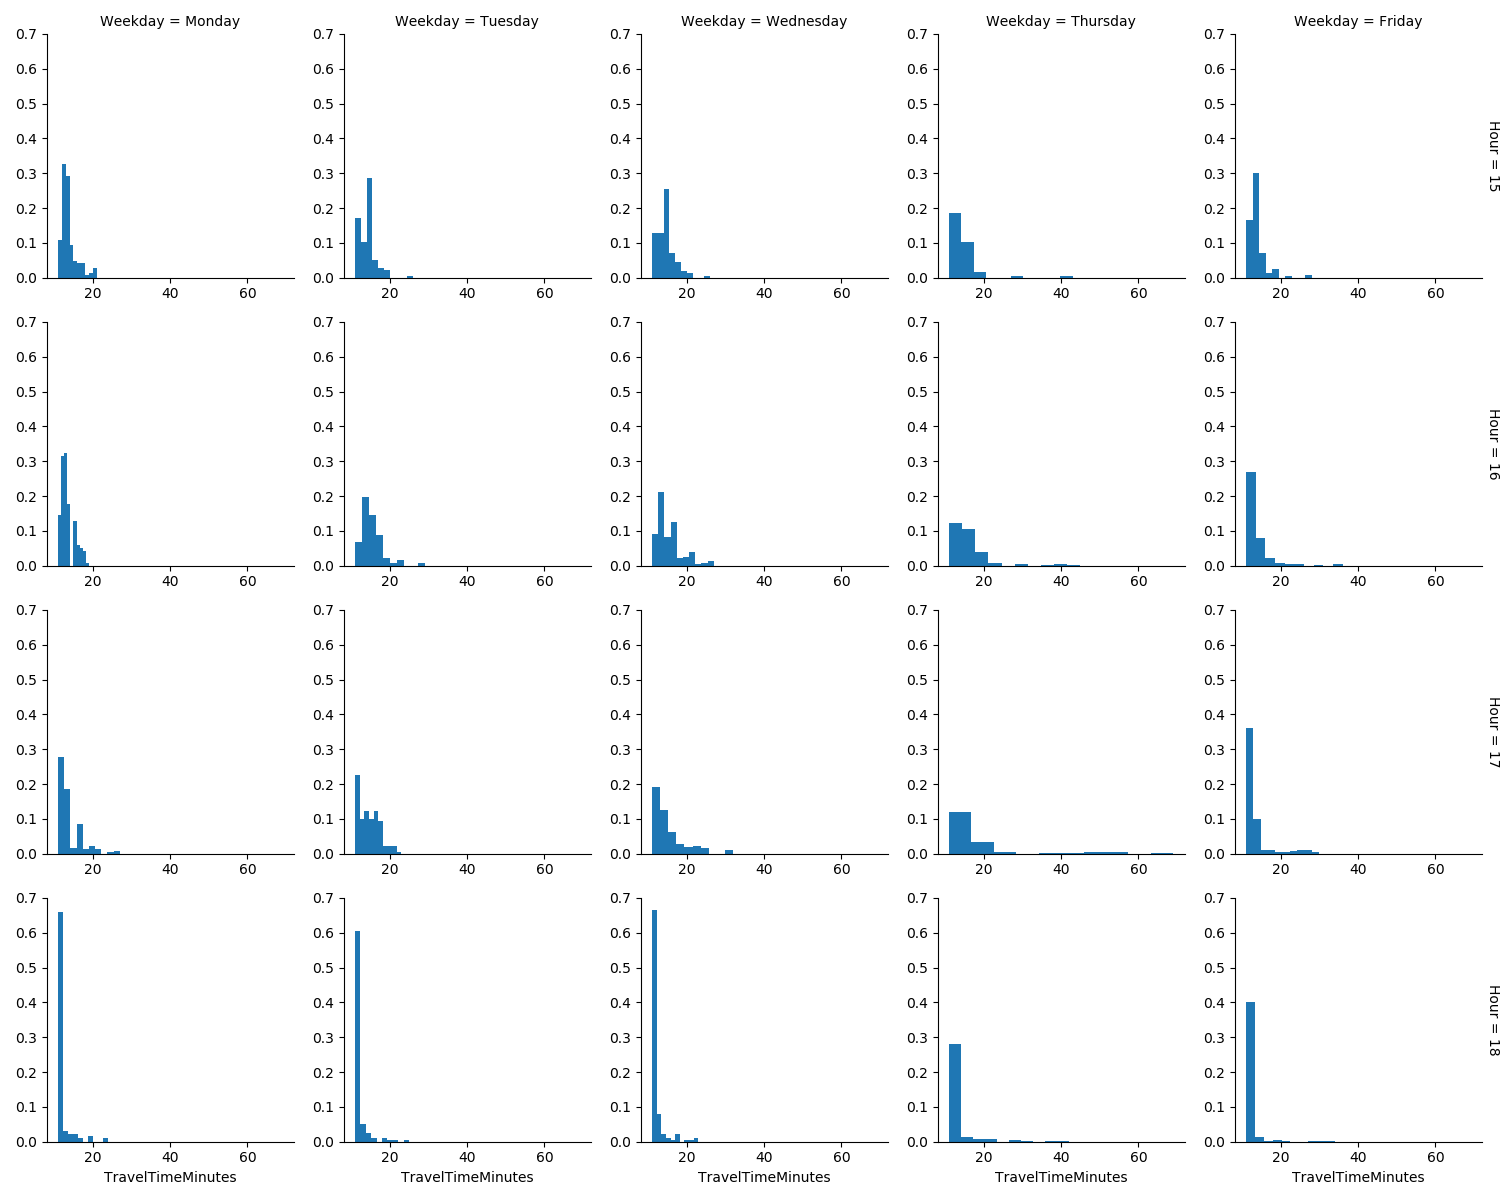

In [181]:
g2 = sns.FacetGrid(tidy, col="Weekday", row="Hour", margin_titles=True)
g2.map(plt.hist, "TravelTimeMinutes", normed=True)